<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/%20%20%20%20AI-ML-analytics-IE/notebooks%20/competitions/segmentation/micrograph_cleaner_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MicrographCleaner - Simple Baseline Solution
This notebook provides a minimal baseline for the MicrographCleaner segmentation challenge using a simple full CNN.

In [ ]:
#Setups and imports
import os
import base64
import io
import zlib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

try:
    import pytorch_lightning as pl
except ImportError:
    !pip install pytorch-lightning
    import pytorch_lightning as pl

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from typing import Optional, Tuple
import torchvision.transforms.v2 as transforms

# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
#Download competition dataset using kaggle.
#If you are in colab, you can manually upload it. I recommend using google drive.
!mkdir -p ~/.kaggle
#You need to change the username and the key to your token (generate it in settings)
#The token looks like a93e6a512d5bc5b5a5a8fa256189b8b8
!echo '{"username": "YOUR_USER","key":"YOUR_TOKEN"}'  > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c micrographs-competition
!unzip -n micrographs-competition

micrographs-competition.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  micrographs-competition.zip


In [ ]:
assert os.path.isfile("train.csv"), "Error, train.csv not found"

### Data loading
Images are encoded as base64 strings. This means that if you open the training CSV files, they will appear as a long, nonsensical block of text. <br>
We need to decode them into numpy arrays to make use of them. <br>
Similarly, when you will prepare your submission file, you need to submit a csv file with the mask images encoded as base64 strings. You will use `encode_array(array)`for that

In [ ]:
def decode_array(encoded_base64_str):
    """
    Utility function to extract the image for the string of bytes that is in the csv file
    """
    decoded = base64.b64decode(encoded_base64_str)
    decompressed = zlib.decompress(decoded)
    return np.load(io.BytesIO(decompressed))


def encode_array(array):
    """
    Utility function to convert a numpy array into a string of bytes to be stored in the csv file
    """
    bytes_io = io.BytesIO()
    np.save(bytes_io, array, allow_pickle=False)
    compressed = zlib.compress(bytes_io.getvalue(), level=9)
    return base64.b64encode(compressed).decode('utf-8')


class BaseMicrographDataset(Dataset):
    """Base class for micrograph datasets implementing common functionality"""

    def __init__(self, df, window_size: int):
        """
        Initialize base dataset

        Args:
            df: Pandas DataFrame containing image data
            window_size: Size of the image window/crop
        """
        self.df = df
        self.window_size = window_size

    def __len__(self) -> int:
        return len(self.df)


    def load_and_normalize_image(self, encoded_image: str) -> torch.Tensor:
        """Load and normalize an encoded image to [0,1] range"""
        image = decode_array(encoded_image).astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min())

        if len(image.shape) == 2:
            image = image[np.newaxis, ...]
        return torch.from_numpy(image)

    def load_mask(self, encoded_mask: str) -> torch.Tensor:
        """Load a mask from encoded string"""
        mask = decode_array(encoded_mask).astype(np.float32)
        if len(mask.shape) == 2:
            mask = mask[np.newaxis, ...]
        return torch.from_numpy(mask)

    def pad_to_min_size(self, image: torch.Tensor, min_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
        """Pad image to minimum size if needed"""
        _, h, w = image.shape
        pad_h = max(0, min_size - h)
        pad_w = max(0, min_size - w)
        padded = torch.nn.functional.pad(image, (0, pad_w, 0, pad_h), mode="reflect")
        return padded, (pad_h, pad_w)


class TrainMicrographDataset(BaseMicrographDataset):
    """Dataset for training with random augmentations"""

    def __init__(self, df, window_size: int):
        super().__init__(df, window_size)

        # Define training-specific transforms
        self.shared_transform = transforms.Compose([
            transforms.RandomCrop(window_size),
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip()
        ])
        self.image_only_transforms = transforms.Compose([
            transforms.GaussianBlur(7, sigma=(0.1, 2.))
        ])

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.df.iloc[idx]

        # Load and preprocess image
        image = self.load_and_normalize_image(row['image'])
        image, _ = self.pad_to_min_size(image, self.window_size)
        image = self.image_only_transforms(image)

        # Load and preprocess mask
        mask = self.load_mask(row['mask'])
        mask, _ = self.pad_to_min_size(mask, self.window_size)

        # Apply shared transforms to both image and mask
        stacked = torch.cat([image, mask], dim=0)
        stacked = self.shared_transform(stacked)
        image, mask = torch.split(stacked, [1, 1], dim=0)

        return image, mask


class ValidationMicrographDataset(BaseMicrographDataset):
    """Dataset for validation using corner crops. This is a good idea because the regions of interest can be
        at the edges of the image"""

    def __init__(self, df, window_size: int):
        super().__init__(df, window_size)
        # Define 5 fixed crops: 4 corners + center
        self.n_crops = 5

    def __len__(self) -> int:
        return len(self.df) * self.n_crops

    def get_crop_coordinates(self, image_shape: Tuple[int, int], crop_idx: int) -> Tuple[int, int]:
        """Get coordinates for specific crop index"""
        h, w = image_shape

        if crop_idx == 4:  # Center crop
            h_start = (h - self.window_size) // 2
            w_start = (w - self.window_size) // 2
        else:
            h_start = 0 if crop_idx < 2 else h - self.window_size
            w_start = 0 if crop_idx % 2 == 0 else w - self.window_size

        return h_start, w_start

    def crop_tensors(self, image: torch.Tensor, mask: torch.Tensor,
                     h_start: int, w_start: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Extract a crop from both image and mask"""
        h_end = h_start + self.window_size
        w_end = w_start + self.window_size

        return (
            image[:, h_start:h_end, w_start:w_end],
            mask[:, h_start:h_end, w_start:w_end]
        )

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_idx = idx // self.n_crops
        crop_idx = idx % self.n_crops
        row = self.df.iloc[image_idx]

        # Load and preprocess image and mask
        image = self.load_and_normalize_image(row['image'])
        image, _ = self.pad_to_min_size(image, self.window_size)

        mask = self.load_mask(row['mask'])
        mask, _ = self.pad_to_min_size(mask, self.window_size)

        # Get specific corner/center crop
        h_start, w_start = self.get_crop_coordinates(image.shape[1:], crop_idx)
        image, mask = self.crop_tensors(image, mask, h_start, w_start)

        return image, mask


class InferenceMicrographDataset(BaseMicrographDataset):
    """Dataset for inference without any augmentations"""

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, str, Tuple[int, int]]:
        row = self.df.iloc[idx]

        # Load and preprocess image
        image = self.load_and_normalize_image(row['image'])
        image, padding = self.pad_to_min_size(image, self.window_size)

        return image, row['Id'], padding

In [ ]:
# A simple full convolutional net in which the image size is kept constant
class SimpleCNN(nn.Module):
    def __init__(self, n_hidden_layers, n_kernels, kernel_size):
        super().__init__()
        self.n_hidden_layers = n_hidden_layers
        layers = [nn.Conv2d(1, n_kernels, kernel_size=kernel_size, padding='same'),
                  nn.GroupNorm(4, n_kernels),
                  nn.PReLU()]

        for _ in range(self.n_hidden_layers):
            layers.extend([
                nn.Conv2d(n_kernels, n_kernels, kernel_size=kernel_size, padding='same'),
                nn.GroupNorm(4, n_kernels),
                nn.PReLU(),
            ])

        layers.extend([
            nn.Conv2d(n_kernels, 1, kernel_size=1),
            nn.Sigmoid()
        ])

        self.conv_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_layers(x)

In [ ]:
class MicrographCleaner(pl.LightningModule):
    def __init__(self, n_hidden_layers=12, n_kernels=16, kernel_size=5, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleCNN(n_hidden_layers, n_kernels, kernel_size)

        self.lossF = nn.BCELoss()
        self.learning_rate = learning_rate

        self.val_imgs_to_log = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.lossF(outputs, masks)

        # Log training metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

        # Log images periodically
        if batch_idx == 0:
            # Log a few samples to tensorboard
            self.logger.experiment.add_images('train_images', images[:4], self.global_step)
            self.logger.experiment.add_images('train_masks', masks[:4], self.global_step)
            self.logger.experiment.add_images('train_predictions', outputs[:4], self.global_step)

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)

        loss = self.lossF(outputs, masks)
        #TODO: Compute IoU to monitor how well we do

        # Log validation metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)

        # Log the first batch of validation images. Since we have several crops, keep only one of them
        if batch_idx < 4: #TODO: You perhaps want to save more images for monitoring, and to select more diverse examples
            self.val_imgs_to_log.append((images[::5], masks[::5], outputs[::5]) )

        return loss

    def on_validation_epoch_end(self) -> None:

        images, masks, outputs = zip(*self.val_imgs_to_log)
        images = torch.cat(images)
        masks = torch.cat(masks)
        outputs = torch.cat(outputs)
        self.logger.experiment.add_images('val_images', images, self.global_step)
        self.logger.experiment.add_images('val_masks', masks, self.global_step)
        self.logger.experiment.add_images('val_predictions', outputs, self.global_step)
        self.val_imgs_to_log = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #TODO: Add a LR scheduler
        return optimizer

In [ ]:
# Tensorboard does not work in kaggle
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs/micrograph_cleaner

In [ ]:
window_size = 512
batch_size = 8
n_epochs = 30

In [ ]:
train_df = pd.read_csv('train.csv')
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = TrainMicrographDataset(train_df, window_size=window_size)
val_dataset = ValidationMicrographDataset(val_df, window_size=window_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

# Initialize model
model = MicrographCleaner()

# Setup training
logger = TensorBoardLogger('lightning_logs', name='micrograph_cleaner')
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='micrograph-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min'
)
#TODO: Add early stopping

# Initialize trainer
trainer = pl.Trainer(
    max_epochs=n_epochs,
    accelerator='auto',
    devices=1,
    #Use limit_batches for fast debugging only
    # limit_val_batches=10,
    # limit_train_batches=10,
    logger=logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10
)

# Train model
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
#Defining the functions for inference
#They are bit more complex than usual, to deal with different image sizes
#In real life, you will have this and the following in a different script
#and you will load the trained model

import tqdm
def sliding_window_inference(model, image, window_size, overlap=0.5):
    """Perform sliding window inference on large images"""
    model.eval()

    # Get dimensions
    _, height, width = image.shape
    stride = int(window_size * (1 - overlap))

    # Calculate number of windows needed
    n_h = int(np.ceil((height - window_size) / stride) + 1)
    n_w = int(np.ceil((width - window_size) / stride) + 1)

    # Create empty prediction map and count map for averaging
    pred_map = torch.zeros((1, height, width)).to(model.device)
    count_map = torch.zeros((1, height, width)).to(model.device)

    # Slide window over image
    with torch.no_grad():
        for i in range(n_h):
            for j in range(n_w):
                # Calculate window boundaries
                h_start = min(i * stride, height - window_size)
                w_start = min(j * stride, width - window_size)
                h_end = h_start + window_size
                w_end = w_start + window_size

                # Extract window
                window = image[:, h_start:h_end, w_start:w_end]

                # If window is smaller than window_size, pad it
                if window.shape[1:] != (window_size, window_size):
                    pad_h = window_size - window.shape[1]
                    pad_w = window_size - window.shape[2]
                    window = torch.nn.functional.pad(window, (0, pad_w, 0, pad_h))

                # Make prediction
                window = window.unsqueeze(0)  # Add batch dimension
                pred = model(window)
                pred = pred.squeeze(0)  # Remove batch dimension

                # If window was padded, remove padding from prediction
                if window.shape[2] - h_end + h_start > 0 or window.shape[3] - w_end + w_start > 0:
                    pred = pred[:, :h_end - h_start, :w_end - w_start]

                # Add prediction to map
                pred_map[:, h_start:h_end, w_start:w_end] += pred
                count_map[:, h_start:h_end, w_start:w_end] += 1

    # Average overlapping predictions
    final_pred = pred_map / count_map
    return final_pred.cpu()


def prepare_submission(model, test_df, window_size, threshold=0.5, overlap=0.5):
    """Create submission file using sliding window inference"""
    test_dataset = InferenceMicrographDataset(test_df, window_size=window_size)

    predictions = []
    unique_ids = set()
    model.eval()
    with torch.inference_mode():
        for idx in tqdm.tqdm(range(len(test_dataset))):
            image, image_id, (pad_h, pad_w) = test_dataset[idx]

            # Skip if we've already processed this image
            if image_id in unique_ids:
                continue
            unique_ids.add(image_id)

            # Perform sliding window inference
            pred = sliding_window_inference(
                model,
                image,
                window_size=window_size,
                overlap=overlap
            )

            if pad_h > 0:
                pred = pred[..., :-pad_h, :]
            if pad_w > 0:
                pred = pred[..., :-pad_w]

            # Convert to binary mask
            pred_mask = (pred > threshold).cpu().numpy()[0]  # Remove channel dimension

            # Encode prediction
            encoded_pred = encode_array(pred_mask)
            predictions.append({
                'Id': image_id,
                'mask': encoded_pred
            })

    # Create submission DataFrame
    submission_df = pd.DataFrame(predictions)
    return submission_df

100%|██████████| 149/149 [03:33<00:00,  1.43s/it]


Submission file created!


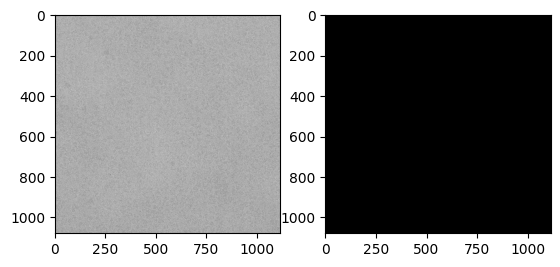

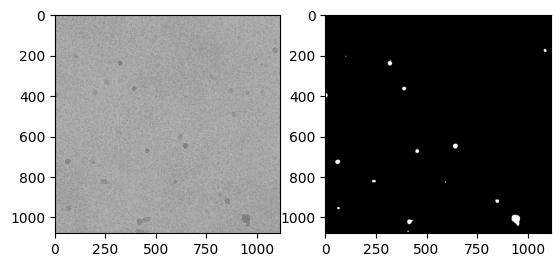

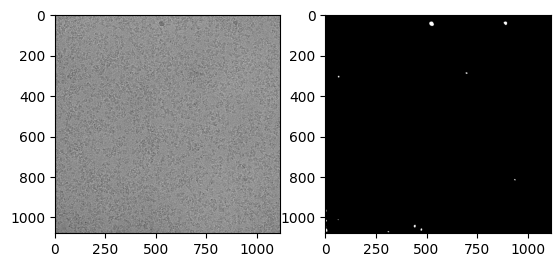

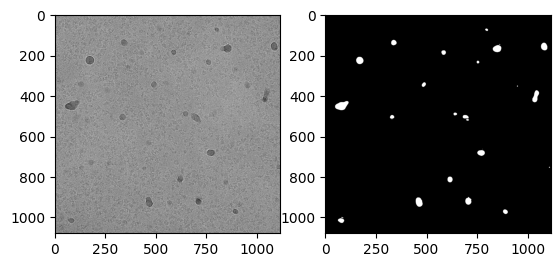

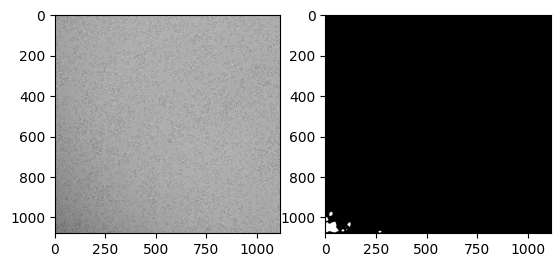

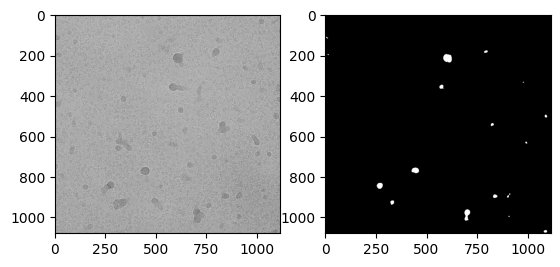

In [ ]:
# Running inference and preparing submission

# model = MicrographCleaner.load_from_checkpoint(checkpoint_filename)

# Create submission
test_df = pd.read_csv('test.csv')
submission_df = prepare_submission(model, test_df, window_size=window_size, threshold=0.5,overlap=0.5)
submission_df.to_csv('submission.csv', index=False)
print("Submission file created!")

for i, row in test_df.iterrows():
    image = decode_array(row["image"])
    mask = decode_array(submission_df["mask"][i])
    f, axes = plt.subplots(1, 2, squeeze=False)
    axes[0, 0].imshow(image, cmap="gray")
    axes[0, 1].imshow(mask, cmap="gray")
    plt.show()
    if i > 4:
      break


In [ ]:
#Code to download the submission.csv file
from IPython.display import FileLink
FileLink("submission.csv")

/kaggle/working/submission.csv

In [ ]:
#Code to download the best checkpoint
import re
from pathlib import Path

def find_best_model(checkpoint_dir: str = "checkpoints") -> str:
    """
    Find the checkpoint with the lowest validation loss in the specified directory.

    Args:
        checkpoint_dir (str): Directory containing the checkpoint files

    Returns:
        str: Path to the best checkpoint file

    Raises:
        ValueError: If no valid checkpoint files are found
    """
    # Ensure the directory exists
    if not os.path.exists(checkpoint_dir):
        raise ValueError(f"Checkpoint directory '{checkpoint_dir}' does not exist")

    # Pattern to match checkpoint files and extract validation loss
    pattern = r"micrograph-epoch=(\d+)-val_loss=(\d+\.\d+)\.ckpt"

    best_loss = float('inf')
    best_checkpoint = None

    # Scan all files in the directory
    for filename in os.listdir(checkpoint_dir):
        match = re.match(pattern, filename)
        if match:
            epoch = int(match.group(1))
            val_loss = float(match.group(2))

            # Update best model if this one has lower validation loss
            if val_loss < best_loss:
                best_loss = val_loss
                best_checkpoint = filename

    if best_checkpoint is None:
        raise ValueError("No valid checkpoint files found")

    best_path = str(Path(checkpoint_dir) / best_checkpoint)
    print(f"Best model found: {best_path}")
    print(f"Validation loss: {best_loss}")

    return best_path


best_model_path = find_best_model()
FileLink(best_model_path)

Best model found: checkpoints/micrograph-epoch=26-val_loss=0.15.ckpt
Validation loss: 0.15


/kaggle/working/checkpoints/micrograph-epoch=26-val_loss=0.15.ckpt

Here are some ways to improve this baseline:


#### Data Handling

- Images are quite large, so it will be difficult to build a model that does not blow up all your memory. I am doing resizing and chuning, with a sliding window approach at inference. There might be better ways of doing it. The corners are specially problematic when an important fraction of the image is labelled as contamination.
- My data normalization is quite simple, there might be room for improvement


#### Model Architecture

- Add more layers/filters
- Experiment with different kernel sizes
- Try different activation functions
- Try other artchitectures like the U-Net


#### Training Improvements

- Add much more data augmentation (remember that if you rotate the image, you also need to rotate the ground truth mask). You could even try to generate fake synthetic data that looks like the experimental data.
- Implement learning rate scheduling
- Use different loss functions (e.g., Dice loss) or combinations of several.


#### Post-processing

- Add threshold tuning. The trehsold of 0.5 might not be the best idea.
- Try morphological operations to fill in the gaps.

#### Other tips
- Remeber saving the model checkpoint and loading it to skip training for experiments that do not require training (e.g., optimizing the threshold).

- Remember visualizing the predictions to get a feeling of how well it is working beyond the number.

- Understand the IoU metric, and use it as part of your evaluation pipeline.